# Développez une preuve de concept

Ce notebook correspond à la tentative d'entraîner un modèle ST-MGCN (voir [Geng et al. 2019](https://ojs.aaai.org/index.php/AAAI/article/view/4247)) sur les données de fréquentation de la Société des Transports en commun de l'Agglomération de Rennes (STAR, accessibles [ici](https://data.explore.star.fr)).


In [3]:
import pandas as pd
import numpy as np
import os
from pyproj import Transformer
import pickle as pkl
import lightgbm as lgb
import torch
import main_stmgcn as mstmgcn
from termcolor import colored
import explainer
from preprocessor import Adj_Preprocessor
import dataloader as dl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import geopandas as gpd

## Preprocessing des données

Dans un premier temps, on préprocesse les données afin de :

- créer quatre matrices d'adjacence
  - de voisinage géographique
  - de connectivité basée sur le réseau des lignes STAR
  - de similarité fonctionnelle entre variables démographiques et fiscales issues de l'INSEE
  - de similarité fonctionnelle entre équipements fournis par la métropole de Rennes
- de traiter les données de fréquentation de sorte à créer target et features

Les données sont prétraitées selon 4 manières d'encoder les matrices de voisinage géographique et de connectivité des transports, de sorte à tester l'effet de plusieurs types d'encodage.


In [ ]:
!bash adj_matrices_combinaison.sh

## Entraînement d'un modèle de référence

Le modèle simple utilisé comme référence est ici une _gradient boosting machine_, entraînée avec le package _LightGBM_.<br>
Ses paramètres sont :

- 50 estimateurs
- profondeur maximale de 4
- taux d'apprentissage de 2e-3


In [ ]:
data = pkl.load(open("data_pandas.pkl", "rb"))

lgb_train = data["train"].dropna()
lgb_valid = data["valid"].dropna()
x_train = lgb_train.drop(columns=["Frequentation", "carreau_index", "DateTime"])
x_valid = lgb_valid.drop(columns=["Frequentation", "carreau_index", "DateTime"])
y_train = lgb_train["Frequentation"]
y_valid = lgb_valid["Frequentation"]

In [ ]:
#!model en utilisant le plus possible les params du papier de ref
model = lgb.LGBMRegressor(
    n_estimators=50, max_depth=4, learning_rate=2e-3, n_jobs=-2, random_state=42
)

#!fit
model.fit(
    X=x_train,
    y=y_train,
    callbacks=[lgb.early_stopping(3)],
    eval_metric=["MSE", "RMSE", "MAPE"],
    eval_set=[(x_valid, y_valid)],
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 3123457, number of used features: 5
[LightGBM] [Info] Start training from score 34.824801
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's l2: 34056.2	valid_0's rmse: 184.543	valid_0's mape: 19.601


LGBMRegressor(learning_rate=0.002, max_depth=4, n_estimators=50, n_jobs=-2,
              random_state=42)

Les performances sont plutôt bonnes, avec une RMSE de 184.5 et une MAPE de 19.6%.


## Entraînement d'un modèle ST-MGCN

Dans un premier temps, on teste les différentes manières l'effet de l'encodage des matrices d'adjacence sur la performance du modèle ST-MGCN.


In [ ]:
for i in range(4):
    print(colored("trial_" + str(i), "red"))
    mstmgcn.train_stmgcn(
        epoch=50,
        batch_size=96,
        learn_rate=2e-3,
        weight_decay=1e-4,
        M_adj=4,
        sta_kernel_config={"kernel_type": "chebyshev", "K": 2},
        loss_opt="MSE",
        device="cuda:0",
        model_dir="./output/240117_" + str(i),
        early_stopper=100,
        idx_adj=i + 1,
        verbose=False,
    )

trial_0
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Training starts at:  Thu Jan 18 13:57:32 2024
Training ends at:  Thu Jan 18 14:16:41 2024
Testing starts at:  Thu Jan 18 14:16:41 2024
valid true MSE:  3632.894
valid true RMSE:  60.273495
valid true MAE:  14.840684
Testing ends at:  Thu Jan 18 14:16:46 2024
training complete
trial_1
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Training starts at:  Thu Jan 18 14:16:46 2024
Training ends at:  Thu Jan 18 14:41:29 2024
Testing starts at:  Thu Jan 18 14:41:29 2

La manière d'encoder les matrices d'adjacence qui amène les meilleures performances est donc :

- aucun seuil de distance
- un encodage discret des connexions entre carreaux dans la matrice de connectivité des transports


Dans un second temps, on cherche à hyperparamétriser le modèle : quelle taille de kernel pour le module de convolution permet d'obtenir les meilleures performances ?


In [ ]:
mse = []
rmse = []
mae = []

for K in range(1, 6):
    print(colored("trial k=" + str(K), "red"))
    res = mstmgcn.train_stmgcn(
        epoch=50,
        batch_size=96,
        learn_rate=2e-3,
        weight_decay=1e-4,
        M_adj=4,
        sta_kernel_config={"kernel_type": "chebyshev", "K": K},
        loss_opt="MSE",
        device="cuda:0",
        model_dir="./output/240117_hyperparam_K" + str(K),
        early_stopper=100,
        idx_adj=2,
        verbose=False,
    )
    mse.append(res[0])
    rmse.append(res[1])
    mae.append(res[2])

trial k=1
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Training starts at:  Thu Jan 18 23:21:23 2024
Training ends at:  Thu Jan 18 23:46:11 2024
Testing starts at:  Thu Jan 18 23:46:11 2024
valid true MSE: 2720.7344
valid true RMSE: 52.16066
valid true MAE: 15.416792
Testing ends at:  Thu Jan 18 23:46:18 2024
training complete
trial k=2
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Training starts at:  Thu Jan 18 23:46:18 2024
Training ends at:  Fri Jan 19 00:11:07 2024
Testing starts at:  Fri Jan 19 00:11:07 

In [ ]:
df = pd.DataFrame({"K": [i for i in range(1, 6)], "rmse": rmse, "mae": mae})
df.to_csv("hyperparameter_k_results.csv", index=False)

Les meilleures performances sont obtenues pour K=4.


On cherche enfin à déterminer si toutes les matrices d'adjacence sont utiles pour prédire la fréquentation, ou si certaines diminuent les performances.


In [ ]:
K = 4
mse = []
rmse = []
mae = []

adj_keys = ["neighbor_adj", "star_adj", "insee_adj", "metro_adj"]
for key in adj_keys:
    print(colored("Training without " + key, "red"))
    res = mstmgcn.train_stmgcn(
        epoch=50,
        batch_size=96,
        learn_rate=2e-3,
        weight_decay=1e-4,
        M_adj=3,
        sta_kernel_config={"kernel_type": "chebyshev", "K": K},  # ! WHAT IS K ???
        loss_opt="MSE",
        device="cuda:0",
        model_dir="./output/240117_without_" + str(key),
        early_stopper=100,
        idx_adj=2,
        drop_adj_list=[key],
        verbose=False,
    )
    mse.append(res[0])
    rmse.append(res[1])
    mae.append(res[2])

Training without neighbor_adj
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Training starts at:  Fri Jan 19 10:23:36 2024
Training ends at:  Fri Jan 19 10:43:09 2024
Testing starts at:  Fri Jan 19 10:43:09 2024
valid true MSE: 3054.4485
valid true RMSE: 55.267067
valid true MAE: 15.841985
Testing ends at:  Fri Jan 19 10:43:14 2024
training complete
Training without star_adj
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Eigen_value calculation didn't converge, using max_eigen_val=2 instead.
Training starts at:  Fri Jan 19 10:43:14 2024
Training ends at:  Fri Jan 19 11:02:52 2024
Testing starts at:  Fri Jan 19 11:02:52 2024
valid true MSE: 2884.8076
valid true RMSE: 53.710403
valid true MAE: 17.641382
Testing ends at:  Fri J

In [ ]:
df1 = pd.DataFrame({"adj": adj_keys, "mse": mse, "rmse": rmse, "mae": mae})
df1.to_csv("remove_adj.csv", index=False)

Enlever la moindre matrice d'adjacence cause une diminution des performances. Toutes les matrices sont donc utiles à la prédiction.


## Explicabilité du modèle ST-MGCN


L'explicabilité locale et globale du modèle est mesurée grâce au package _Captum_.<br>
On cherche ici à déterminer le score d'importance (calculé par l'_integrated gradient_) de trois types de variables :

- les connexions du réseau de transports en commun
- la demande aux pas de temps précédents
- les variables fonctionnelles issues de Rennes Métropole

Pour ce faire, on calcule ces scores sur 500 observations tirées aléatoirement du training set.


In [7]:
model = mstmgcn.load_stmgcn(
    "output/240117_hyperparam_K4/ST_MGCN_best_model.pkl",
    sta_kernel_config={"kernel_type": "chebyshev", "K": 4},
)
#! data loader
data = pkl.load(open("data2.pkl", "rb"))
adj = pkl.load(open("adj_matrices2.pkl", "rb"))
carreaux = pkl.load(open("carreaux2.pkl", "rb"))
metro = pd.read_csv("rennes_metro2.csv")
data_loader = dl.get_data_loader(data, 1, "cuda:0", True)

#! kernel list
sta_adj_list = list()
for key in list(adj.keys()):
    adj_preprocessor = Adj_Preprocessor(kernel_type="chebyshev", K=4)
    adj_mat = torch.from_numpy(adj[key]).float()
    adj_mat = adj_preprocessor.process(adj_mat)
    sta_adj_list.append(adj_mat.to("cuda:0"))

star_explanations = []
metro_explanations = []
time_explanations = []
star_explanations_sat = []
metro_explanations_sat = []
time_explanations_sat = []
saturation = []
true_saturation = []
i = 0
for x, y in data_loader["train"]:
    if i % 10 == 0:
        print(i)
    star_explanations.append(
        explainer.explain_star(x, adj["star_adj"], sta_adj_list, 1, model)
    )
    metro_explanations.append(
        explainer.explain_metro(x, metro.to_numpy(), sta_adj_list, 3, model)
    )
    time_explanations.append(explainer.explain_time(x, sta_adj_list, model))
    saturation.append(min(np.sum(y.cpu().detach().numpy()) / 50000, 1))
    true_saturation.append(np.sum(y.cpu().detach().numpy()))
    i += 1
    if i >= 500:
        break
explanations = {
    "star": star_explanations,
    "metro": metro_explanations,
    "time": time_explanations,
    "saturation": saturation,
    "tsaturation": true_saturation,
}
pkl.dump(explanations, open("explanations_model.pkl", "wb"))

model loaded
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [41]:
explanations = pkl.load(open("explanations_model.pkl", "rb"))

La figure ci-dessous montre l'importance relative de la demande aux différents pas de temps antérieurs. La demande la plus importante pour prédire la fréquentation à un pas de temps est celle à l'heure précédente (_t-1h_).


/tmp/ipykernel_993233/2469007128.py:11: RuntimeWarning: invalid value encountered in divide
  np.where(np.abs(x).max() > 0, x / np.abs(x).max(), x)


Text(0.5, 0, 'Relative feature importance')

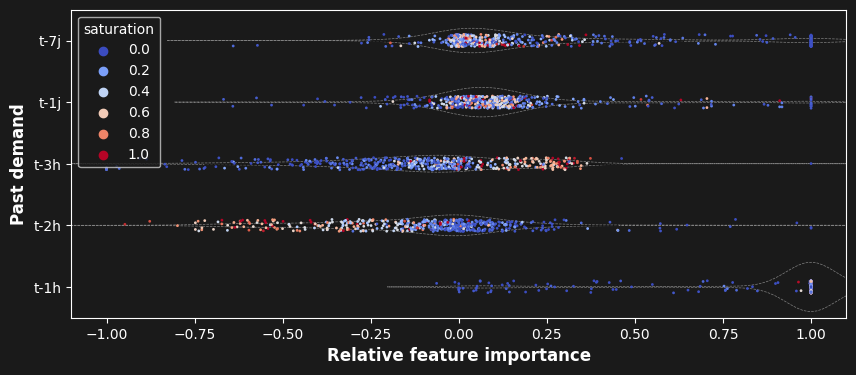

In [ ]:
plt.style.use("custom_dark")

time = pd.DataFrame(
    np.array(
        [
            np.where(np.abs(x).max() > 0, x / np.abs(x).max(), x)
            for x in explanations["time"]
        ]
    ),
    columns=["t-7j", "t-1j", "t-3h", "t-2h", "t-1h"],
)
time = time.stack().reset_index()
time["saturation"] = np.concatenate([[x] * 5 for x in explanations["saturation"]])
# sns.violinplot(data=time, x=0, y="level_1")
fig = plt.figure(figsize=(10, 4))
ax = sns.violinplot(data=time, x=0, y="level_1", color="#1A1A1A", linewidth=0.5)
for i in ax.collections:
    i.set_edgecolor("gray")
    i.set_linestyle("--")
sns.stripplot(
    data=time, x=0, y="level_1", hue="saturation", palette=plt.cm.coolwarm, s=2
)
plt.ylabel("Past demand")
plt.xlabel("Relative feature importance")

La figure suivante compare les importances relatives totales des différents types de variables.


Text(0.5, 0, 'Aggregated relative feature importance')

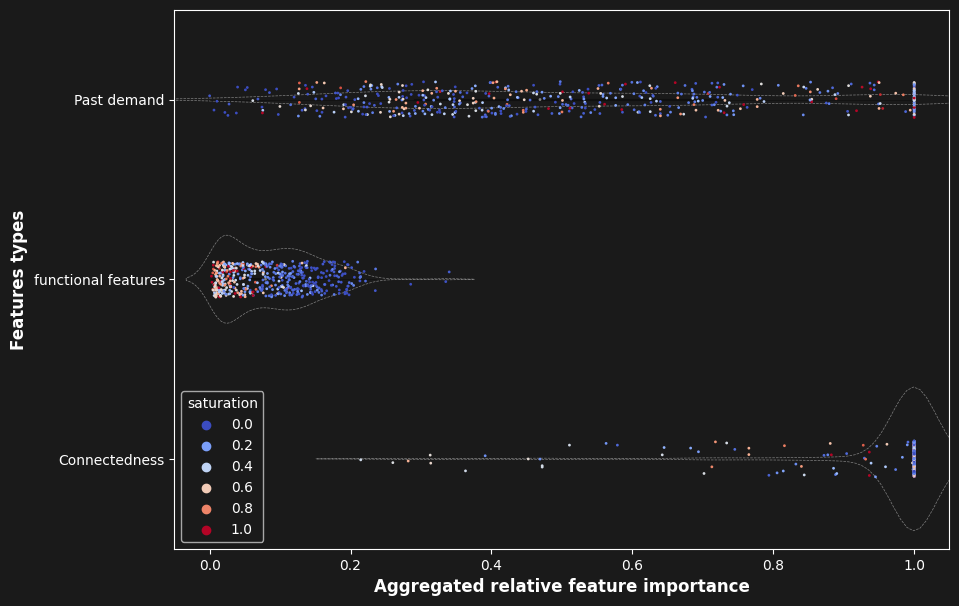

In [ ]:
#!agg des scores pour effets globaux
time = [np.sum(np.abs(x)) for x in explanations["time"]]
metro = [np.sum(np.abs(x)) for x in explanations["metro"]]
star = [np.sum(np.abs(x)) for x in explanations["star"]]
exp = pd.DataFrame(
    {"Past demand": time, "functional features": metro, "Connectedness": star}
)
exp = exp.divide(exp.max(axis=1), axis=0)

exp = exp.stack().reset_index()
exp["saturation"] = np.concatenate(
    [[x] * 3 for x in explanations["saturation"]])

#! effet globaux des variables
fig = plt.figure(figsize=(10, 7))
ax = sns.violinplot(data=exp, x=0, y="level_1", color="#1A1A1A", linewidth=0.5)
for i in ax.collections:
    i.set_edgecolor("gray")
    i.set_linestyle("--")
sns.stripplot(
    data=exp, x=0, y="level_1", hue="saturation", palette=plt.cm.coolwarm, s=2
)
plt.ylabel("Features types")
plt.xlabel("Aggregated relative feature importance")

La figure suivante représente l'importance relative des différentes variables fonctionnelles.


Text(0.5, 0, 'Relative feature importance')

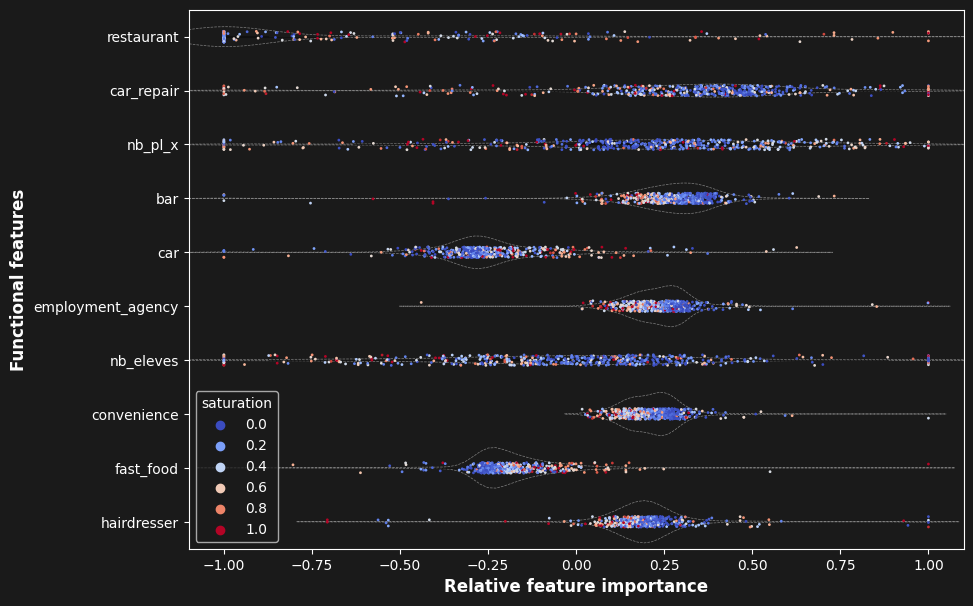

In [ ]:
plt.style.use("custom_dark")
metro = pd.read_csv("rennes_metro2.csv")
funct = pd.DataFrame(
    np.array([x / np.abs(x).max() for x in explanations["metro"]]),
    columns=metro.columns,
)
funct = funct.stack().reset_index()
funct["saturation"] = np.concatenate(
    [[x] * funct["level_1"].nunique() for x in explanations["saturation"]]
)
funct = funct[funct["level_1"] != "nb_pl_y"]
funct_med = funct.groupby("level_1").apply(
    lambda x: np.abs(x).median()).reset_index()
funct_med.sort_values(by=0, ascending=False, inplace=True)
funct_med = funct_med[funct_med["level_1"].isin(
    funct_med["level_1"].unique()[:10])]
funct = funct[funct["level_1"].isin(funct_med["level_1"].unique())]
funct["level_1"] = pd.Categorical(
    funct["level_1"], categories=funct_med["level_1"].unique()
)
funct.sort_values(by="level_1", ascending=True, inplace=True)
fig = plt.figure(figsize=(10, 7))
ax = sns.violinplot(data=funct, x=0, y="level_1",
                    color="#1A1A1A", linewidth=0.5)
for i in ax.collections:
    i.set_edgecolor("gray")
    i.set_linestyle("--")
sns.stripplot(
    data=funct, x=0, y="level_1", hue="saturation", palette=plt.cm.coolwarm, s=2
)
plt.ylabel("Functional features")
plt.xlabel("Relative feature importance")

La figure suivante représente les 50 connexions les plus importantes dans le réseau de connectivité, pour les 500 observations.


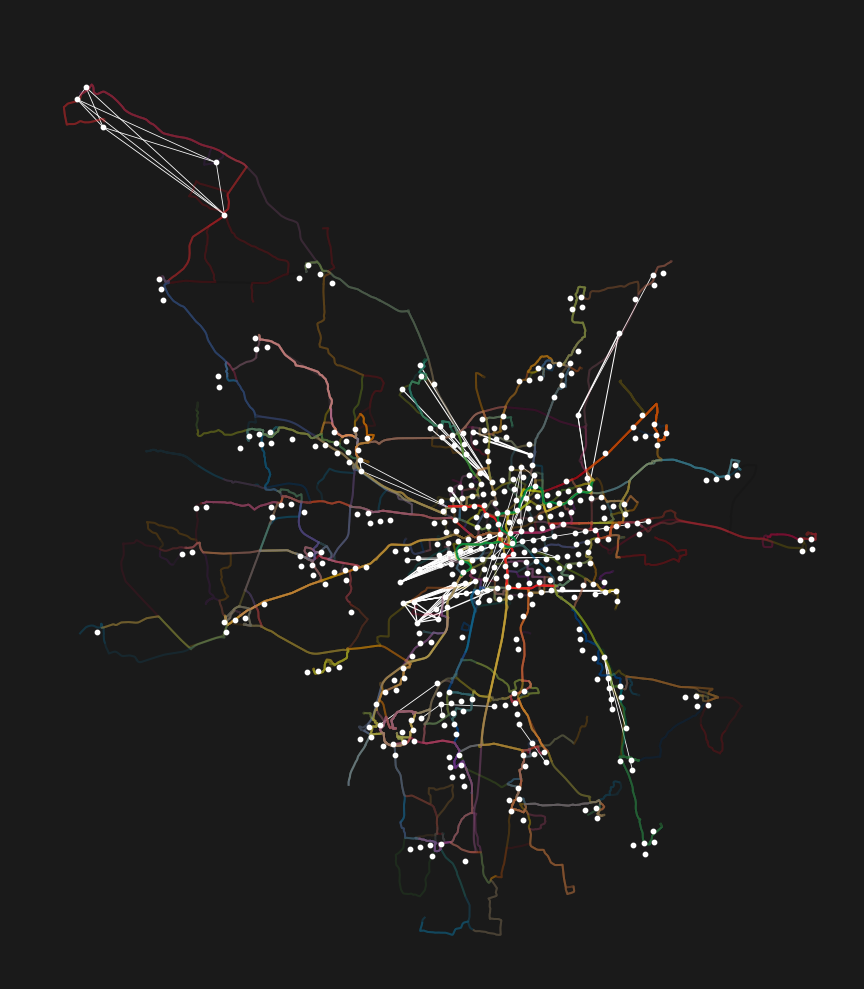

In [8]:
#!importation geojson
bus = gpd.read_file("tco-bus-topologie-parcours-td.geojson")
metro = gpd.read_file("tco-metro-topologie-parcours-td.geojson")

#!chargement de carreaux (idx et coord)
transformer = Transformer.from_crs("EPSG:3035", "EPSG:4326")
carreaux = pkl.load(open("carreaux2.pkl", "rb"))
carreaux = pd.DataFrame({"index": carreaux})
#!séparation des coord en comp nord et est
carreaux["north"] = carreaux["index"].str.split("N").str[0].astype(float)
carreaux["east"] = (
    carreaux["index"].str.split("N").str[1].str.split("E").str[0].astype(float)
)
#!passage des coor en lat et long
latlong = transformer.transform(carreaux["north"], carreaux["east"])
carreaux["north"] = latlong[0]
carreaux["east"] = latlong[1]

#! Synthèse des valeurs pour onbenir un futur réseau compact/lisible
g_expl = sum([np.abs(x) / np.abs(x).max() for x in explanations["star"]]) / len(
    explanations["star"]
)

#!creation du réseau et association avec la carte chargée
plt.style.use("custom_dark")
fig, ax = plt.subplots(figsize=(10, 10))  # , facecolor="white"
ax.set_axis_off()
ax = bus.plot(ax=ax, color=bus["couleurtrace"], alpha=0.1)
ax = metro.plot(ax=ax, color=metro["couleurtracetrace"], alpha=0.7)
g = nx.from_numpy_array(g_expl)
edges = sorted(g.edges(data=True), key=lambda x: x[2]["weight"], reverse=True)[:100]
# essai d'amélioration des poids pour rep graph
weights = [2 * np.sqrt(x[2]["weight"]) for x in edges]
edges = [(a, b) for a, b, c in edges]
nx.draw_networkx(
    g,
    carreaux[["east", "north"]].to_numpy(),
    with_labels=False,
    ax=ax,
    node_size=10,
    node_color="white",
    edgelist=edges,
    width=weights,
    edge_color="white",
)
plt.tight_layout()

La figure suivante représente les 50 connexions les plus importantes dans le réseau de connectivité, pour une observation.


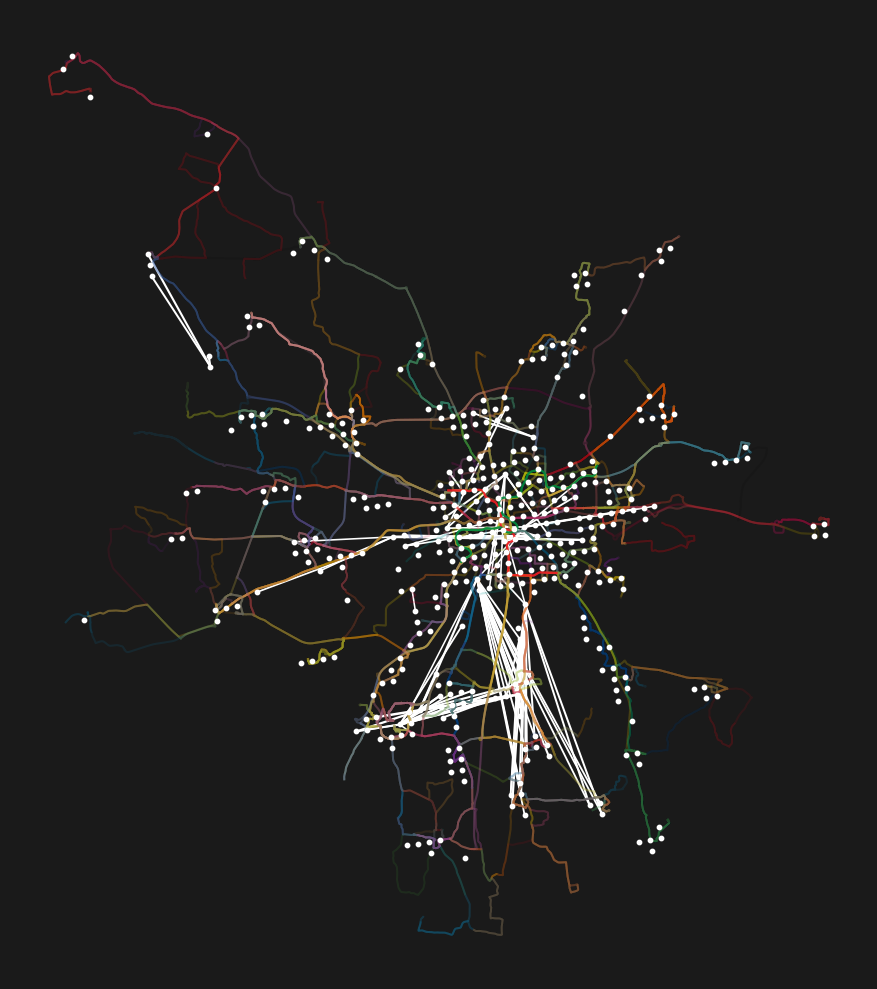

In [9]:
#!importation geojson
bus = gpd.read_file("tco-bus-topologie-parcours-td.geojson")
metro = gpd.read_file("tco-metro-topologie-parcours-td.geojson")

#!chargement de carreaux (idx et coord)
transformer = Transformer.from_crs("EPSG:3035", "EPSG:4326")
carreaux = pkl.load(open("carreaux2.pkl", "rb"))
carreaux = pd.DataFrame({"index": carreaux})
#!séparation des coord en comp nord et est
carreaux["north"] = carreaux["index"].str.split("N").str[0].astype(float)
carreaux["east"] = (
    carreaux["index"].str.split("N").str[1].str.split("E").str[0].astype(float)
)
#!passage des coor en lat et long
latlong = transformer.transform(carreaux["north"], carreaux["east"])
carreaux["north"] = latlong[0]
carreaux["east"] = latlong[1]

#! Synthèse des valeurs pour onbenir un futur réseau compact/lisible
g_expl = np.abs(explanations["star"][0]) / \
    np.abs(explanations["star"][0]).max()

#!creation du réseau et association avec la carte chargée
plt.style.use("custom_dark")
fig, ax = plt.subplots(figsize=(10, 10))  # , facecolor="white"
ax.set_axis_off()
ax = bus.plot(ax=ax, color=bus["couleurtrace"], alpha=0.1)
ax = metro.plot(ax=ax, color=metro["couleurtracetrace"], alpha=0.7)
g = nx.from_numpy_array(g_expl)
edges = sorted(g.edges(data=True),
               key=lambda x: x[2]["weight"], reverse=True)[:100]
# essai d'amélioration des poids pour rep graph
weights = [2 * np.sqrt(x[2]["weight"]) for x in edges]
edges = [(a, b) for a, b, c in edges]
nx.draw_networkx(
    g,
    carreaux[["east", "north"]].to_numpy(),
    with_labels=False,
    ax=ax,
    node_size=10,
    node_color="white",
    edgelist=edges,
    width=weights,
    edge_color="white",
)
plt.tight_layout()

## Entraînement sur un jeu de données externe

Le modèle ST-MGCN donne une très mauvaise MAPE (>100%) sur le jeu de données considéré ici. Cela pourrait s'expliquer par la présence de nombreuses valeurs nulles dans ce jeu de données, qui tendraient à rendre la MAPE inefficiente à mesurer les performances réelles du jeu de données.<br>
Afin de tester cette hypothèse, on cherche à entraîner et tester le modèle ST-MGCN sur un autre jeu de données, accessible [ici](https://github.com/water-wbq/2019-ZJU_SummerResearch/tree/master/OriginalData).


In [1]:
mstmgcn.train_stmgcn_external(
    epoch=50,
    batch_size=96,
    learn_rate=2e-3,
    weight_decay=1e-4,
    M_adj=3,
    sta_kernel_config={"kernel_type": "chebyshev", "K": 0},
    loss_opt="MSE",
    device="cuda:0",
    model_dir="./output/external",
    early_stopper=100,
    verbose=True,
)

Training starts at:  Fri Jan 26 12:14:05 2024
Epoch 1, Val_loss drops from inf to 7241.0. Update model checkpoint..
Epoch 2, Val_loss drops from 7241.0 to 1277.4. Update model checkpoint..
Epoch 3, Val_loss drops from 1277.4 to 954.49. Update model checkpoint..
Epoch 4, Val_loss drops from 954.49 to 905.23. Update model checkpoint..
Epoch 5, Val_loss does not improve from 905.23.
Epoch 6, Val_loss drops from 905.23 to 882.07. Update model checkpoint..
Epoch 7, Val_loss does not improve from 882.07.
Epoch 8, Val_loss drops from 882.07 to 878.86. Update model checkpoint..
Epoch 9, Val_loss drops from 878.86 to 864.84. Update model checkpoint..
Epoch 10, Val_loss drops from 864.84 to 852.95. Update model checkpoint..
Epoch 11, Val_loss does not improve from 852.95.
Epoch 12, Val_loss does not improve from 852.95.
Epoch 13, Val_loss does not improve from 852.95.
Epoch 14, Val_loss does not improve from 852.95.
Epoch 15, Val_loss does not improve from 852.95.
Epoch 16, Val_loss drops from 8

(825.98956, 28.740034, 13.896984)